""" Rb Raman pulse scan
    Preston Huft, May 2019    
"""

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import complex_ode,odeint
from scipy.integrate import solve_ivp
import sympy
from sympy import MatrixSymbol,MatAdd,MatMul,Identity,I,Matrix,symbols
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy.utilities.iterables import flatten
import time
from math import pi,sqrt

In [2]:
## physical constants
e = 1.60217662e-19 # [C]
a0 = 5.22e-11 # [m]
hbar = 1.0545718e-34 # [J s]
c = 3e8 # [m]
e0 = 8.85418782e-12 # [m^-3 kg^-1 s^4 A^2]

In [93]:
###############################################################################
## METHODS and GLOBAL PARAMETERS
###############################################################################

## Methods

def cc(z): 
    return np.conj(z)  


def Intensity(P,w0,r,A=None,r0=None):
    """ Gaussian beam intensity at radius 'r' for
        'P' power
        'w0' beam waist
        'A' area
    """
    if r0 is None:
        r0 = 0
    if A is None:
        A = pi*w0**2
    
    return (P/A)*np.exp(-(r-r0)**2/(2*w0**2))

def z_rayleigh(w0,wl):
    return (pi*w0**2)/wl

def g_waist(z,w0,zR):
    return w0*sqrt(1+(z/zR)**2)  

## "GLOBAL" VARIABLES (scope excludes method bodies)

lmbda = 7.8e-7 # [m] wavelength
o1DipoleElem = -1.792e-29 # see rb_matrix_elements
o2DipoleElem = 1.792e-29

C:\Users\gothr\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: ComplexWarning: Casting complex values to real discards the imaginary part


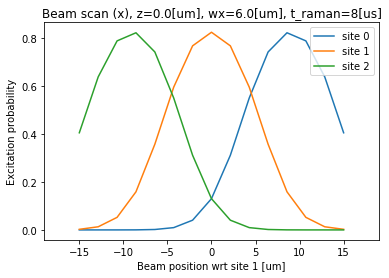

In [97]:
###############################################################################
## Raman 8 us pulse beam position scan for three atom sights
###############################################################################

def derivs(y0,t,D1,D2,O1,O2):
    cg,ce = y0
    
    # See Mark's notes, eqs 11.14. Intermediate level r eliminated.
    
    D = D1-D2 # resonant when the single-photon detunings cancel
    DD1 = D - cc(O1)*O1/(D1+D2)
    DD2 = D + cc(O2)*O2/(D1+D2)
    OR = O1*cc(O2)/(D1+D2)
    
    dcg = -1j*(DD1*cg-cc(OR)*ce)/2
    dce = 1j*(DD2*ce+OR*cg)/2
    
    return np.array([dcg,dce])


## initial conditions - system starts in ground state (|F=2,mF=0>)
c_g = 1 + 0j
c_e = 0 + 0j
y0 = np.array([c_g,c_e]) # bundle i.c.

## empirical parameters and pertinent quantities
P = 2*(3.5e-6) # [W] beam power per sideband at atoms
D1 = D2 = 2*pi*(4.5e10) # [Hz] single-photon detuning

# experiment lists/variables 
pts = 15 # data pts to plot per atom site
r_vals = np.linspace(-15e-6,15e-6,pts) # the positions to scan 
sites = 3 # number of atom sites
D_arr = [0,0,0] # site-specific detuning due to different trap depths
spacing = 9e-6 # [m] spacing between atom sights in x direction
dr = [-spacing,0,spacing]
retention = []

t_exp = 8 # [us] # raman pulse duration

## Build beam waist and area arrays:
w0x = 6e-6 # [m] w0 in x direction
w0y = 8e-6 # [m] w0 in y direction
zRx = z_rayleigh(w0x,lmbda) 
zRy = z_rayleigh(w0y,lmbda)

z_vals = np.linspace(0,zRy,4) 
x_waists = np.array([g_waist(z,w0x,zRx) for z in z_vals])
A_vals = np.array([pi*g_waist(z,w0x,zRx)*g_waist(z,w0y,zRy) for z in z_vals])

z=0 # 0 is at focus, -1 is at Rayleigh range
wx = x_waists[z] # waist at x
A = A_vals[z] # area at z=0

## initialize the figure
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_ylim((0,1))
ax.set_xlim(-19,19)
ax.set_ylabel('Excitation probability')

for s in range(0,sites): # iterate over the sites

    # The two-photon Rabi frequency
    O_vals = (2/(c*e0*hbar**2))*Intensity(P,wx,r_vals+dr[s],A,r0=None) \
        *o1DipoleElem*o2DipoleElem \
        /(2*D1)
    
    retention.append(np.empty(len(r_vals)))
    for i,O in enumerate(O_vals/(2*pi*1e6)): # iterate over Rabi freq. vals 
        
        # The single-photon Rabi frequency
        # Assume O1=O2=O, which is true if |r>=|5p3/2,F=2,mF=1>
        O1=O2=sqrt(abs(O*(D1+D2)))

        func = lambda time,y: derivs(y,time,D1,D2,O1,O2)
        soln = solve_ivp(func,[0,t_exp],y0,t_eval=np.linspace(0,t_exp,50))
        ce = soln.y[1][-1]
        retention[s][i]=cc(ce)*ce
    ax.set_title('Positional scan of beam over atom site')
    ax.set_xlabel('Beam position wrt site 1 [um]')    
    ax.plot(r_vals*1e6,retention[s],label=f"site {s}")

ax.set_title(f'Beam scan (x), z={z_vals[z]/1e-6}[um], wx={wx/1e-6}[um], t_raman={t_exp}[us]')
ax.legend(loc='upper right')
plt.show()

In [39]:
z_vals

array([0.00000000e+00, 6.44429262e-05, 1.28885852e-04, 1.93328779e-04,
       2.57771705e-04])

In [43]:
zRx

0.0001449965840118366